In [108]:
# For now aerobulk installation only worked on greene not laptop
import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from aerobulk.flux import noskin_np, skin_np, noskin, skin

%load_ext autoreload
%autoreload 3

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [109]:
# atm has 576 * 360 grid
# ocn has 3600 * 2700 grid
from mlflux.utils import sort_longitude

atm = xr.open_dataset('../../data/Global/GFDL_CM2p6_control_atm_0101.nc', chunks={})
atm['t_ref'] = atm['t_ref'] 

ocn = xr.open_dataset('../../data/Global/GFDL_CM2p6_control_ocn_0101.nc', chunks={})
ocn = ocn.isel(time=0)

ocn = ocn.rename({'xt_ocean': 'lon', 'yt_ocean': 'lat'})
ocn = sort_longitude(ocn)
atm['sst'] = ocn.surface_temp.interp(lon=atm['grid_xt'],lat=atm['grid_yt']) + 273.15
ocn = ocn.rename({'lon': 'xt_ocean', 'lat': 'yt_ocean'})

ocn = ocn.rename({'xu_ocean': 'lon', 'yu_ocean': 'lat'})
ocn = sort_longitude(ocn)
atm['usurf'] = ocn.usurf.interp(lon=atm['grid_xt'],lat=atm['grid_yt'])
atm['vsurf'] = ocn.vsurf.interp(lon=atm['grid_xt'],lat=atm['grid_yt'])
ocn = ocn.rename({'lon': 'xu_ocean', 'lat': 'yu_ocean'})

In [ ]:
# VALID_VALUE_RANGES = {
#     "sst": [270, 320],
#     "t_zt": [180, 330],
#     "hum_zt": [0, 0.08],
#     "u_zu": [-50, 50],
#     "v_zu": [-50, 50],
#     "slp": [80000, 110000],
#     "rad_sw": [0, 1500],
#     "rad_lw": [0, 750],
# }

In [113]:
atm["ps_adjust"] = atm["ps"].where((atm["ps"] < 110000) & (atm["ps"] > 80000), 101000)
sst_wet_mask = ~np.isnan(atm['sst'])
ds = atm.where(sst_wet_mask.compute())

In [112]:
sst_wet_mask = ~np.isnan(atm['sst'])
ds = atm.where(sst_wet_mask).isel(grid_xt=slice(None,None), grid_yt=slice(40,-1))

ql, qh, taux, tauy, evap = \
noskin(sst=ds.sst, t_zt=ds.t_ref, 
       hum_zt=ds.q_ref, u_zu=ds.wind, 
       v_zu=ds.wind*0, slp=ds.ps_adjust, 
       algo='coare3p0', zt=ds.wind/ds.wind*2., zu=ds.wind/ds.wind*10.,
       input_range_check=True)

print(qh.values)

/ext3/miniconda3/lib/python3.11/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)


ValueError: Found values in slp that are out of the valid range (80000-110000).

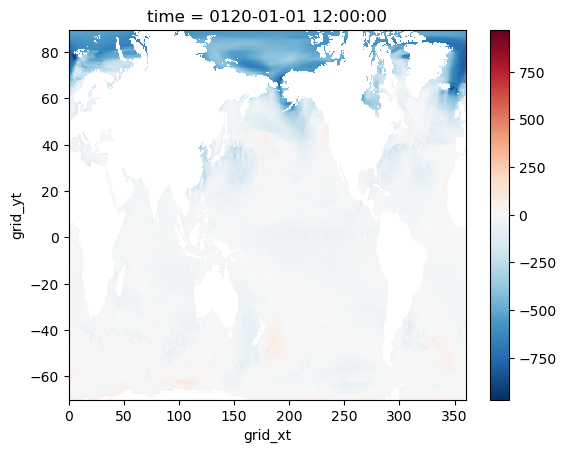

In [107]:
qh.plot()

In [57]:
# algo = 'coare3p6'
sst_wet_mask = ~np.isnan(atm['sst'])
ds = atm.where(sst_wet_mask.compute())

ql, qh, taux, tauy, evap = \
noskin(sst=ds.sst, t_zt=ds.t_ref, 
       hum_zt=ds.q_ref, u_zu=ds.wind, 
       v_zu=ds.wind*0, slp=ds.ps_adjust, 
       algo='ncar', zt=ds.wind/ds.wind*2., zu=ds.wind/ds.wind*10.)

/ext3/miniconda3/lib/python3.11/site-packages/aerobulk/flux.py:280: UserWarning: Checking for misaligned nans and values outside of the valid range is performed by default, but reduces performance. 
If you are sure your data is valid you can deactivate these checks by setting `input_range_check=False`
  warnings.warn(performance_msg)


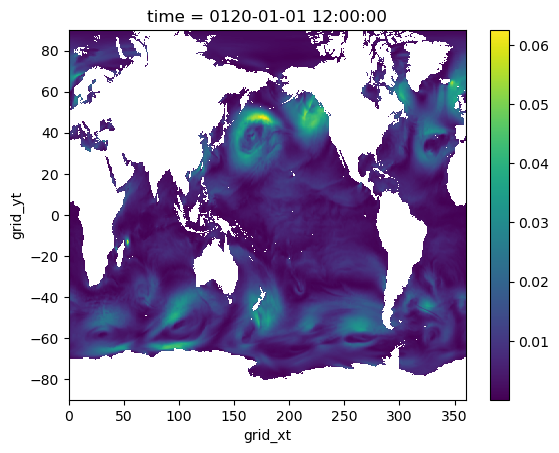

In [48]:
taux.plot()

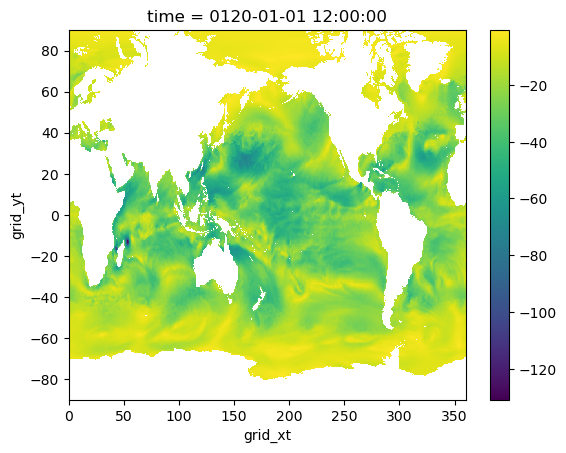

In [52]:
ql.plot()

In [ ]:
# https://github.com/ocean-transport/scale-aware-air-sea/blob/main/scale_aware_air_sea/stages.py

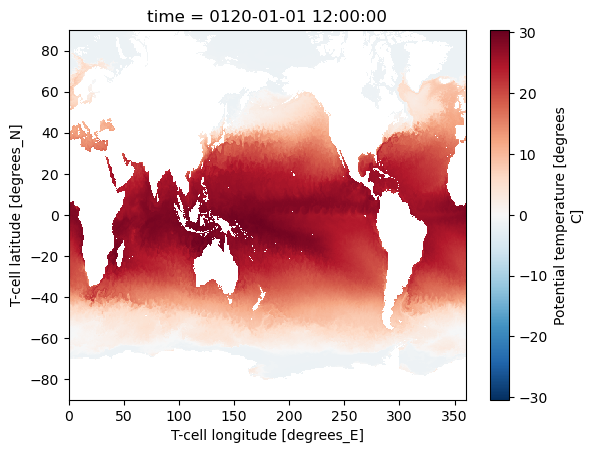

In [9]:
ds.sst.plot()